 ## [Dataset](https://catalog.data.gov/dataset/u-s-chronic-disease-indicators-cdi)

### U.S. Chronic Disease Indicators (CDI)

CDC's Division of Population Health provides cross-cutting set of 124 indicators that were developed by consensus and that allows states and territories and large metropolitan areas to uniformly define, collect, and report chronic disease data that are important to public health practice and available for states, territories and large metropolitan areas. (from CDC website)

The indicators are set up in the column ["Questions"] and are classified in one of the 17 health topics. Each Question is answered for several diferent Stratification categories and data is provided in several diferent data value types. The dataset as provided is in long format on state and national level for years between  2008 and 2020. Some Values are given as average over a range of years. The range can be seen in YearStart and YearEnd columns. 

<table border="1" cellspacing="0" cellpadding="5">
    <thead>
        <tr>
            <th>Topic</th>
            <th>Stratification Categories</th>
            <th>Data Types</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Asthma</td>
            <td>Asian or Pacific Islander</td>
            <td>Number</td>
        </tr>
        <tr>
            <td>Cancer</td>
            <td>Black, non-Hispanic</td>
            <td>Average Annual Number</td>
        </tr>
        <tr>
            <td>Chronic Kidney Disease</td>
            <td>Female</td>
            <td>Crude Prevalence</td>
        </tr>
        <tr>
            <td>Chronic Obstructive Pulmonary Disease</td>
            <td>Male</td>
            <td>Age-adjusted Rate</td>
        </tr>
        <tr>
            <td>Cardiovascular Disease</td>
            <td>Overall</td>
            <td>Local control of the regulation of alcohol outlet density</td>
        </tr>
        <tr>
            <td>Diabetes</td>
            <td>American Indian or Alaska Native</td>
            <td>Crude Rate</td>
        </tr>
        <tr>
            <td>Disability</td>
            <td>Hispanic</td>
            <td>Age-adjusted Prevalence</td>
        </tr>
        <tr>
            <td>Reproductive Health</td>
            <td>White, non-Hispanic</td>
            <td>US Dollars</td>
        </tr>
        <tr>
            <td>Tobacco</td>
            <td>Multiracial, non-Hispanic</td>
            <td>Commercial host (dram shop) liability status for alcohol service</td>
        </tr>
        <tr>
            <td>Alcohol</td>
            <td>Other, non-Hispanic</td>
            <td>Per capita alcohol consumption</td>
        </tr>
        <tr>
            <td>Arthritis</td>
            <td>-</td>
            <td>Average Annual Age-adjusted Rate</td>
        </tr>
        <tr>
            <td>Nutrition, Physical Activity, and Weight Status</td>
            <td>-</td>
            <td>Average Annual Crude Rate</td>
        </tr>
        <tr>
            <td>Mental Health</td>
            <td>-</td>
            <td>Adjusted by age, sex, race and ethnicity</td>
        </tr>
        <tr>
            <td>Older Adults</td>
            <td>-</td>
            <td>Prevalence</td>
        </tr>
        <tr>
            <td>Oral Health</td>
            <td>-</td>
            <td>Yes/No</td>
        </tr>
        <tr>
            <td>Overarching Conditions</td>
            <td>-</td>
            <td>Percent</td>
        </tr>
        <tr>
            <td>Immunization</td>
            <td>-</td>
            <td>Mean</td>
        </tr>
        <tr>
            <td>-</td>
            <td>-</td>
            <td>Median</td>
        </tr>
        <tr>
            <td>-</td>
            <td>-</td>
            <td>Age-adjusted Mean</td>
        </tr>
    </tbody>
</t   |            |
   |            |
    

                 

 aset/u-s-chronic-disease-indicators-cdid level



)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, Dropdown
import missingno as msno


Use the cell below to download the complete dataset from the cdc website.

In [ ]:
!wget = -O ../data/U.S._Chronic_Disease_Indicators__CDI_.csv https://data.cdc.gov/api/views/g4ie-h725/rows.csv?accessType=DOWNLOAD

In [3]:
df = pd.read_csv('../data/U.S._Chronic_Disease_Indicators__CDI_.csv', low_memory=False)

### Missing Data

We will use missingno python library to quickly check the distribution of null values in our columns. In the resulting matrix below, one can see from a sample of 10,000 rows that columns pertainig to Startification categories 2 and 3, Response and ResponseID are completly empty. We will drop those to reduce the dimensiopnality of the dataset.

There is also some redundancy in the dataset. Specificaly some columns have a duplicate columnNameID. For our purpose we can also safely drop these.



<Axes: >

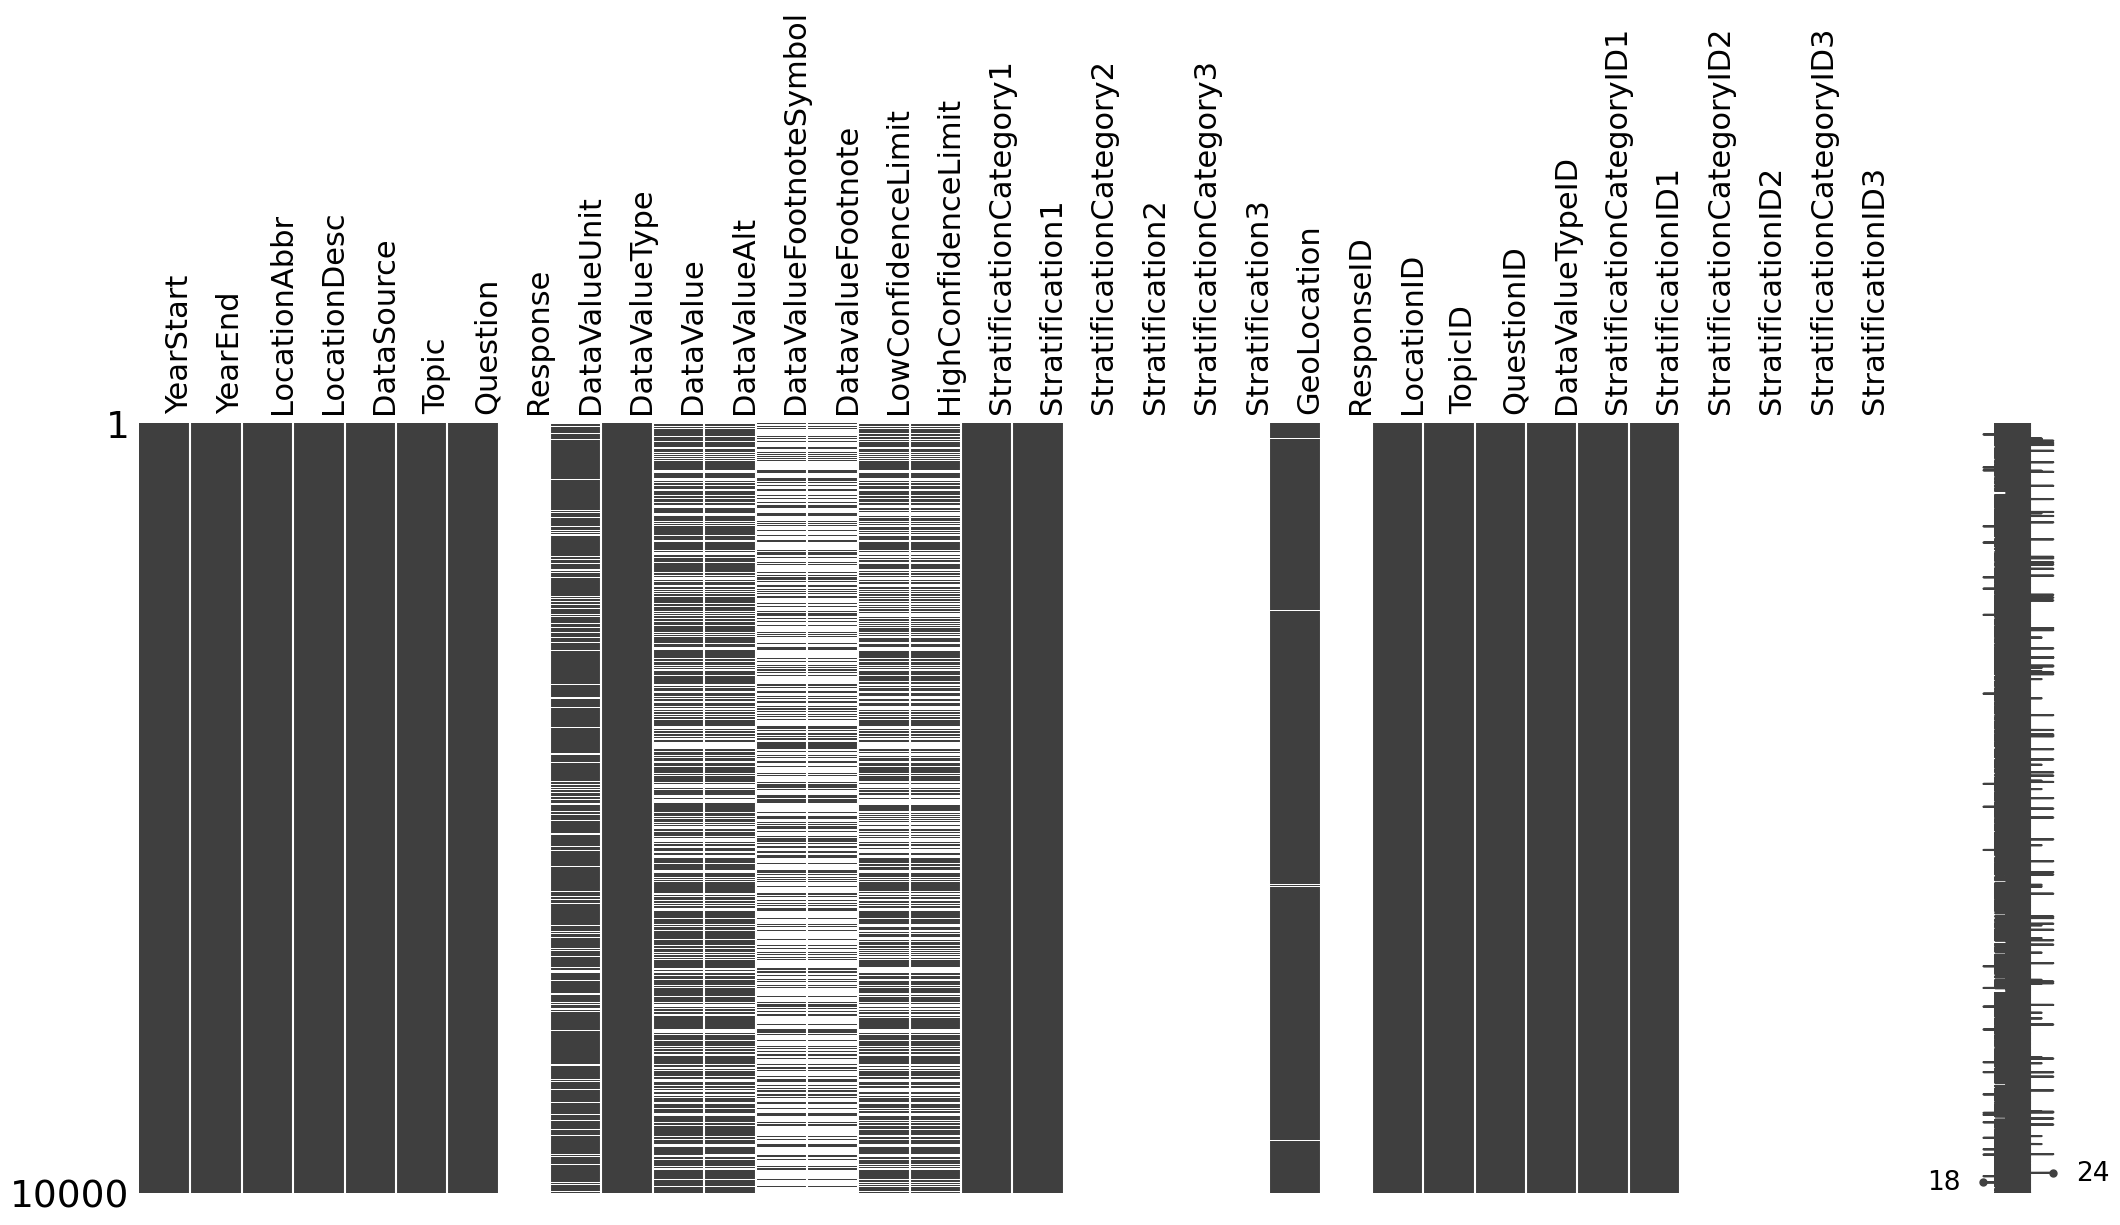

In [4]:
msno.matrix(df.sample(10000), fontsize=22, label_rotation=90)

In [5]:
redundant_columns = ['LocationID', 'TopicID', 'QuestionID', 'DataValueTypeID', 'DataValueAlt', 'StratificationCategoryID1', 'StratificationID1']

# Check for columns that are completly empty and put them in a list
empty_columns = df.columns[df.isnull().all()].tolist()

# Concatenate all columns we need to drop into a single list
columns_to_drop = redundant_columns + empty_columns

df = (df
     .drop(columns_to_drop, axis='columns')
     )

<Axes: >

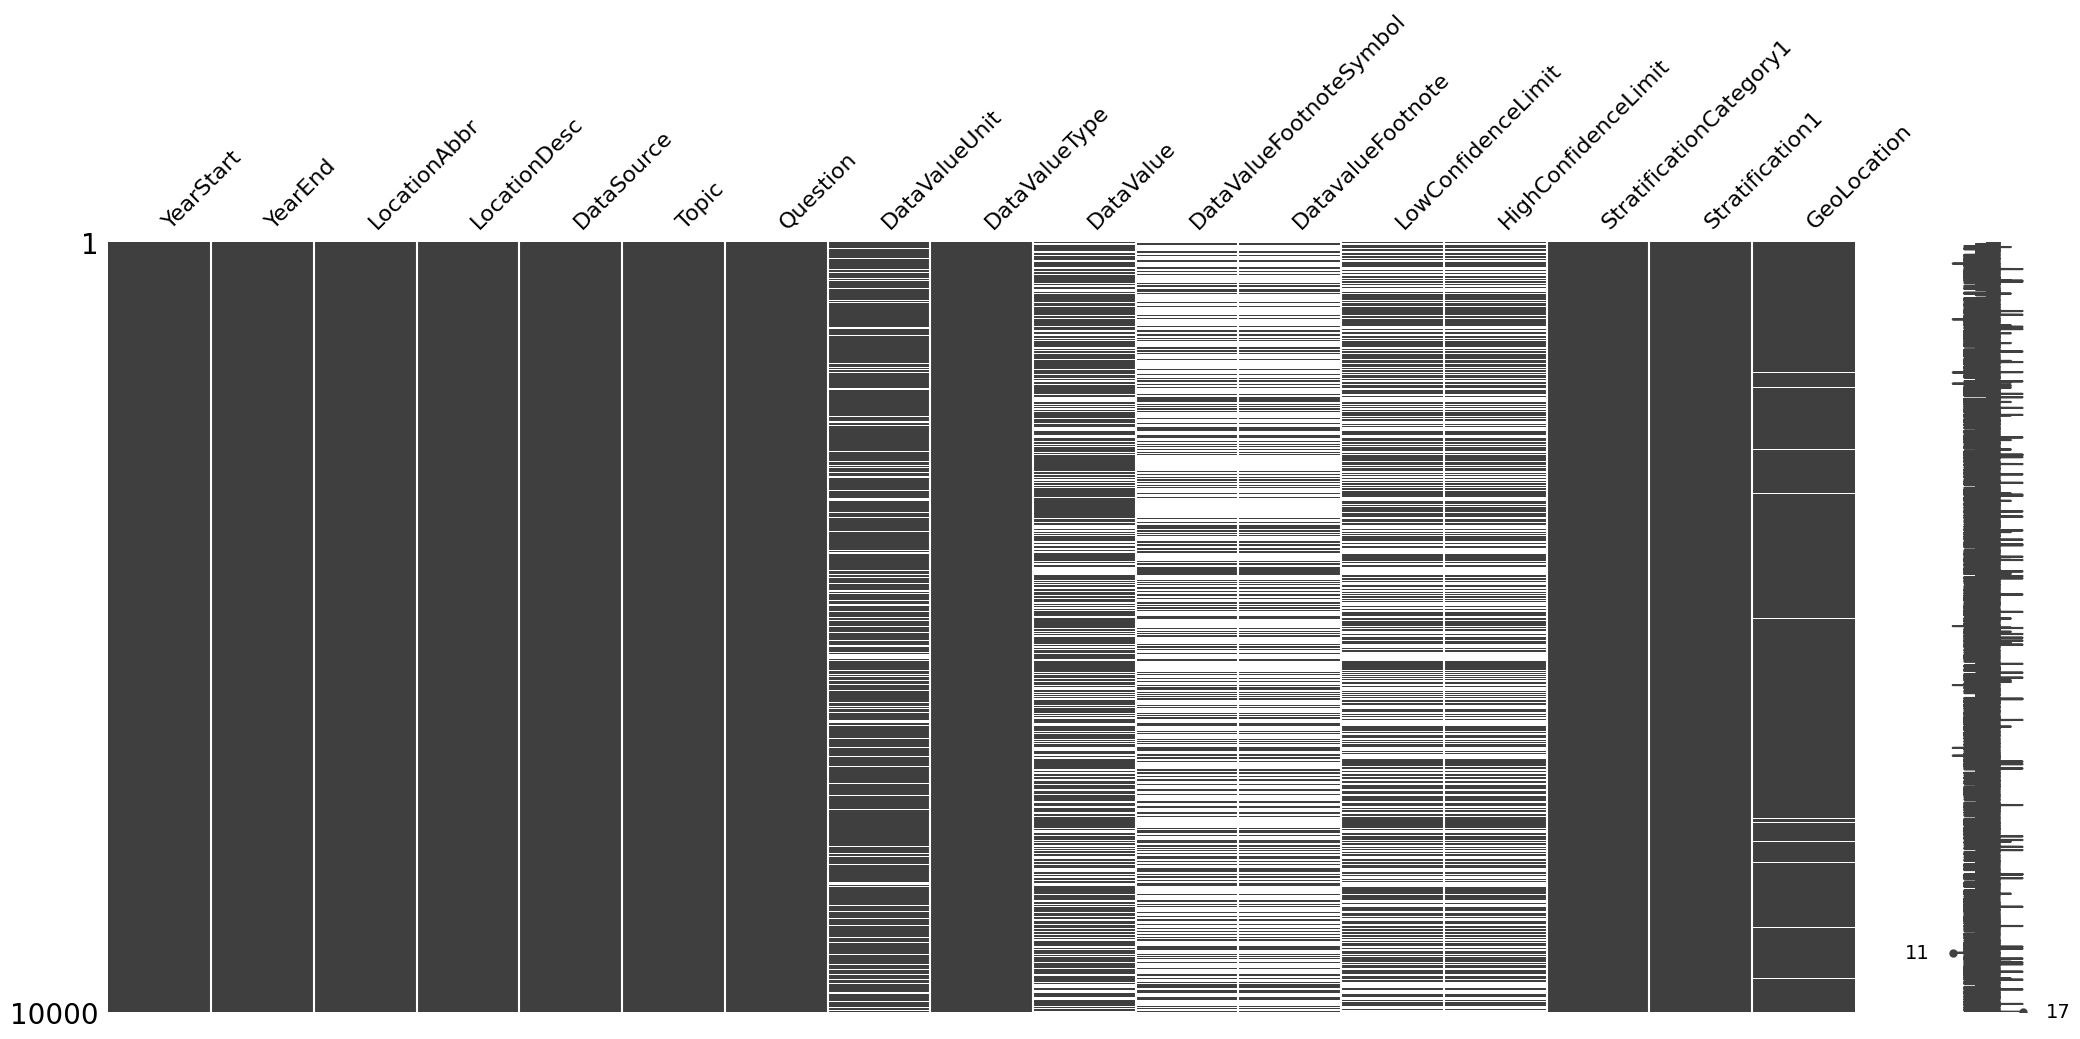

In [6]:
msno.matrix(df.sample(10000))

### Outliers and missing data

We have discussed imputing missing data, but have decided to leave the dataset as is. The Chatbot should answer the questions based on the data collected not some imputed data for which we have no confindence in beeing correct.

Another issue are outliers. By removing any outliers we might be removing some interesting information. Due to overwhelming number of indicators and Value types we will rather add some information to the dataset and let the user who is interested in particular data point do the next step and decide weather this is something to explore further.

To expose where on the distribution the particular datapoint lies we will compute a z score for each datapoint and add a flag to all rows containg data more than 3 $\sigma$ from the mean.>gn*}−μ
​


$
\begin{aligned}
\( z = \frac{X - \mu}{\sigma} \)
\end{aligned}
$

In [7]:
class DataProcessor:
    def __init__(self, dataframe: pd.DataFrame):
        self.data = dataframe

    def preprocess_data_value(self, row):
        value = str(row['DataValue'])
        dtype = row['DataValueType']
        dunit = str(row['DataValueUnit'])

        # Return NaN for rows where data value type is 'yes/no'
        if dunit == 'nan':
            return float('nan')
        else: return float(value)
        
        
    def compute_grouped_z_score(self, value_column: float, group_columns: list) -> None:
        """
        Compute z-score for a specific column, grouped by other columns.
        
        Parameters:
            - preprocess_value_column: Name of the column containig original data
            - value_column: Name of the column for which z-score is to be computed.
            - group_columns: Columns to group by before computing the z-score.
        """
        z_score_column = f"{value_column}_z_score"

        # Preprocess the DataValue column
        self.data['ProcessedDataValue'] = self.data.apply(self.preprocess_data_value, axis=1)
        
        # Compute mean and std within groups
        group_means = self.data.groupby(group_columns)[value_column].transform('mean')
        group_stds = self.data.groupby(group_columns)[value_column].transform('std')

        
        self.data[z_score_column] = (self.data[value_column] - group_means) / group_stds
        
    def get_data(self) -> pd.DataFrame:
        """
        Get the processed dataframe.
        
        Returns:
            - Processed dataframe with computed z-scores.
        """
        return self.data

processor = DataProcessor(df)
processor.compute_grouped_z_score("ProcessedDataValue", ['Topic', "Question", "LocationDesc", "DataValueType", "Stratification1"])
df = processor.get_data()


Lets get a visual of how our data looks like. Choose one or two indicators to coompare. Make sure you choose something where same datatype is available.

In [8]:

def update_question_options(change):
    question_widget.options = df[df['Topic'] == topic_widget.value]['Question'].unique()

def interactive_time_series_plot(topic, question, stratification, type, state1, state2):
    # Filter the dataframe based on the chosen parameters
    mask = (df['Question'] == question) & (df['Stratification1'] == stratification) & \
          (df['DataValueType'] == type) & (df['LocationDesc'].isin([state1, state2]))
    plot_df = df[mask]
    plot_df.DataValue = pd.to_numeric(plot_df.DataValue)
    
    if plot_df.empty:
        print("No data available for the selected parameters.")
        return

    
    plt.figure(figsize=(14,7))
    sns.lineplot(data=plot_df, x='YearStart', y='DataValue', hue='LocationDesc')
    plt.title(f'Time Series for {question}')
    plt.show()
    plt.close()

# Create widgets
topic_widget = Dropdown(options=df['Topic'].unique(), description='Topic')
topic_widget.observe(update_question_options, names='value')

question_widget = Dropdown(description='Question')
type_widget = Dropdown(options=df['DataValueType'].unique(), description='type')
state_widget_1 = Dropdown(options=df['LocationDesc'].unique(), description='State 1')
state_widget_2 = Dropdown(options=df['LocationDesc'].unique(), description='State 2')
stratification_widget = Dropdown(options=df['Stratification1'].unique(), description='Stratification')

interact(interactive_time_series_plot, 
         topic=topic_widget, 
         question=question_widget, 
         stratification=stratification_widget,
         type=type_widget,
         state1=state_widget_1, 
         state2=state_widget_2);

interactive(children=(Dropdown(description='Topic', options=('Cardiovascular Disease', 'Alcohol', 'Arthritis',…

One source of redundancy and additional complexity  are multiple different data value types for each Indicator at every timepoint. To simplifie the dataset further and improve accuracy we keep only one "datavaluetype" per indicator.
We choose to keep the most common "datavaluetype" accross all indicators that is available.

In [9]:
# Create an ordered list of DataValueType from most common to least common
ordered_datavalue_types = df['DataValueType'].value_counts().index.tolist()
ordered_datavalue_types

['Crude Prevalence',
 'Age-adjusted Prevalence',
 'Number',
 'Age-adjusted Rate',
 'Crude Rate',
 'Average Annual Number',
 'Average Annual Crude Rate',
 'Average Annual Age-adjusted Rate',
 'Mean',
 'Age-adjusted Mean',
 'Median',
 'Percent',
 'Yes/No',
 'US Dollars',
 'Adjusted by age, sex, race and ethnicity',
 'Per capita alcohol consumption',
 'Local control of the regulation of alcohol outlet density',
 'Commercial host (dram shop) liability status for alcohol service',
 'Prevalence']

In [10]:
# Create an empty DataFrame to store the filtered data
filtered_df = pd.DataFrame()

# Iterate over each unique Question
for question in df['Question'].unique():
    # Filter the DataFrame for the current question
    question_df = df[df['Question'] == question]

    # Iterate over the ordered DataValueTypes
    for datatype in ordered_datavalue_types:
        if datatype in question_df['DataValueType'].values:
            # Select the first DataValueType that is available for this question
            selected_df = question_df[question_df['DataValueType'] == datatype]

            # Append the selected data to the filtered DataFrame
            filtered_df = pd.concat([filtered_df, selected_df])

            # Once the first available type is found and data is appended, break the loop
            break

In [11]:
filtered_df.to_csv('../data/filtered_data.csv', index=False)

Another approach at improving accuarcy is unpivoting the dataset from its long to wide form.

In [12]:
unpivoted = df.pivot(index=['LocationDesc', 'YearStart'], columns=['StratificationCategory1', 'Stratification1', 'DataValueType', 'Question', ], values='DataValue')


In [13]:
unpivoted.to_json('../data/cdc_data.json')

In [14]:
unpivoted.to_csv('../data/cdc_data.csv')